In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image

In [151]:
from game_assets.utils import simplify_image, save_img
from conv_rgb.model import ConvRGB

In [152]:
from pysimulacra.data import SimulacraData

ds = SimulacraData('../raw_data/sac_public_2022_06_29.sqlite')

# data = ds.fetch_all_data()

In [153]:
'raw_data/sac-000000'

'raw_data/sac-000000'

In [154]:
# 'simulacra-aesthetic-captions'

In [155]:
# img_df = ds.get_image_paths_and_prompts()

In [156]:
img_df = ds.get_image_paths_and_prompts_and_ratings()
img_df

,img_id,img_prompt,img_path,img_rating
0,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,7
1,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,1
2,6,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,4
3,5,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
4,4,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
...,...,...,...,...
176934,248438,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,5
176935,248439,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,7
176936,248440,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,6
176937,248441,avatar of a dragon knight anato finnstark yosi...,43044_avatar_of_a_dragon_knight_anato_finnstar...,5


In [157]:
def square_image(pil_img):
    
    width, height = pil_img.size # Get dimensions
    
    if width < height:
        new_width, new_height = width, width
    else:
        new_width, new_height = height, height
        
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = pil_img.crop((left, top, right, bottom))
    
    return im

In [158]:
timg = Image.open('../raw_data/sac-000000/11175_3.png')

In [199]:
from PIL import ImageDraw, ImageFont
import textwrap

def simplify_image(pil_img, num_colors = 8, size = (256, 256)):

    img = pil_img.quantize(colors=num_colors, method=2)
    
    sq_img = square_image(img).resize(size, Image.LANCZOS)
    
    return sq_img

def add_border(old_img, width = 6, caption = None, caption_size = 12):
    
    img_arr = np.array(old_img)

    old_size = old_img.size
    
    new_size = [size + width for size in old_size]
    
    if caption:
        caption_wrapped = textwrap.wrap(caption, width=18)
        new_size[1] += (caption_size + 1) * len(caption_wrapped)
        
        
    new_img = Image.new("RGB", new_size, 'White')
    #box = tuple((n - o) // 2 for n, o in zip(new_size, old_size)) # centered
    box = tuple((new_size[0] - o) // 2 for o in old_size)
    new_img.paste(old_img, box)
    
    if caption:
        draw = ImageDraw.Draw(new_img)
        # font = ImageFont.truetype(<font-file>, <font-size>)
        #font = ImageFont.truetype("sans-serif.ttf", 16)
        # draw.text((x, y),"Sample Text",(r,g,b))
        
        font = ImageFont.truetype('../dejavu-sans-mono/DejaVuSansMono.ttf', caption_size)
        
        for idx, line_text in enumerate(caption_wrapped):
            draw.text((width/2, old_size[0] + (width/2) + (idx * caption_size)), line_text.upper(), (0,0,0), font=font)

    return new_img

In [200]:
240

240

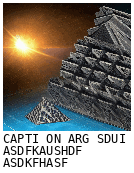

In [201]:
timg = Image.open('../raw_data/sac-000000/11175_3.png')
timg = simplify_image(timg, num_colors = 256, size = (128, 128))
add_border(timg, caption = "capti on arg sdui asdfkaushdf asdkfhasf")

In [202]:
def shorten_path(img_path):
    name_parts = img_path.split('_')
    new_name = f'{name_parts[0]}_{name_parts[-1]}'
    return new_name

In [203]:
import regex as re
import string

def clean_png_path(file_name):
    
    file_name = file_name.replace(',', ' ')
    
    #suffix = file_name[-4:]
    
    clean_file_name = re.sub(r'[^A-Za-z0-9 ]+', '', file_name)
    
#     if clean_file_name == "":
#         clean_file_name
    
    return '_'.join(clean_file_name.split()) # + suffix


In [204]:
img_df['short_img_path'] = img_df.img_path.apply(shorten_path)

img_df['clean_prompt'] = img_df.img_prompt.apply(clean_png_path)

240

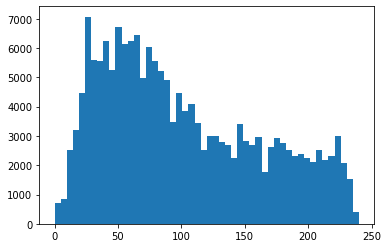

In [205]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in img_df['clean_prompt']], bins = 50);
max([len(x) for x in img_df['clean_prompt']])

In [47]:
# https://github.com/google-research-datasets/conceptual-captions/blob/master/LICENSE
# https://ai.google.com/research/ConceptualCaptions/download

# data = pd.read_csv('../raw_data/Validation_GCC-1.1.0-Validation.tsv', sep = '\t', header = None)
# data.columns = ['caption', 'url']

In [206]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device) # "ViT-B/32"

def clip_encode_image(pil_img):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    image = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features


In [207]:
colour_model = ConvRGB(input_shape = (240, 240), n_cut = 8)

In [208]:
import matplotlib.pyplot as plt

def colours_as_pct(input_images):
#     print(np.min(input_images))
    images = np.add(np.ones(input_images.shape), input_images)
#   images = images + 1 # avoid dividing by zero
#     if np.min(images) == '0':
#     print('min:',  np.min(images))
#     print(type(images))
#     print(images)
#     plt.imshow(images[0] / 255)
#     plt.show()
        
#     images = np.true_divide(images, images.sum(axis=-1, keepdims=True))
    
    images = images / images.sum(axis=-1, keepdims=True)
    return images

In [209]:
def colour_encode_image(pil_img):
    
    img = pil_img.resize((240, 240))
    
    X = np.expand_dims(np.array(img), axis = 0)
    
    X = colours_as_pct(X)
    
    colour_features = colour_model(X)
    
    return colour_features

In [210]:
# img_array_list = [np.array(Image.open(f'../raw_data/sac_images2/{image_path}')) for image_path in image_path_list]

In [211]:
def get_common_colors(img_array_list, top_k = 256):

    all_na = np.array(img_array_list)

    all_colours, all_counts = np.unique(all_na.reshape(-1,3), axis=0, return_counts=1) 
    
    threshold = sorted(counts)[-top_k]
    
    col_palette = (colours[counts >= threshold] * 255).astype(np.uint8).reshape((16, 16, 3))
    
    return col_palette


In [212]:
from itertools import product

def gen_color_palette(init_size):
    
    values = np.linspace(0, 255, init_size).astype(np.uint8)

    rgb_pal = np.array(list(product(values, repeat=3)))
    
    return rgb_pal

In [213]:
# fig, axes = plt.subplots(10, 1, figsize = (2, 2))

# for i, ax in enumerate(axes.flat):
#     rgb_pal = gen_color_palette(i + 2)
#     ax.imshow(rgb_pal.reshape(i + 2, -1, 3))
#     ax.set_xticks([])
#     ax.set_yticks([])
    
# plt.savefig('../results/color_stack.png', facecolor = 'white')

In [ ]:
# 8-bit colour scheme is not always the same
# https://stackoverflow.com/questions/17728757/do-all-8-bit-colors-exist-in-24-bit-color-space-if-so-how-to-map

In [214]:
def qcolour_encode_image(pil_img, return_img = False):
    
    # could maybe increase the number of colour features ?

    colour_palette  = gen_color_palette(4)

    colour_palette_long = colour_palette.reshape(-1)

    pal_img = Image.new('P', (16, 16))
    pal_img.putpalette(list(colour_palette_long) * 4)

    q_img = pil_img.resize((16, 16)).quantize(palette=pal_img, dither=0, method=2)
    
    new_rgb_img = Image.new('RGB', (16, 16), 0xFF)
    new_rgb_img.paste(q_img)
    
    rgb_img = np.array(new_rgb_img) 
    
    # Get used colours and counts of each
    colours, counts = np.unique(rgb_img.reshape((-1,3)), axis=0, return_counts=1)
    
    # create dict of all possible colour features
    colour_counter = {k.tobytes(): 0 for k in colour_palette}
    
    for i in range(len(colours)):

        idx = colours[i].tobytes()

        count = counts[i]

        colour_counter[idx] = count
        
    features = np.array(list(colour_counter.values()))

    if return_img:
        return features, rgb_img
    else:
        return features


In [215]:
def plot_quantrgb(pil_img):
    
    f, axes = plt.subplots(1, 2, figsize = (12, 6))

    axes[0].imshow(pil_img)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    

    features, new_img = qcolour_encode_image(pil_img, return_img = True)
    axes[1].imshow(new_img)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

In [1868]:
os.listdir('../raw_data/sac-000000/')

['25308_2.png',
 '13941_1.png',
 '26058_1.png',
 '38376_1.png',
 '1280_4.png',
 '16742_2.png',
 '7322_7.png',
 '10188_1.png',
 '13474_3.png',
 '8254_4.png',
 '15654_6.png',
 '8440_5.png',
 '16996_5.png',
 '7278_5.png',
 '31379_2.png',
 '5478_7.png',
 '9110_4.png',
 '5732_8.png',
 '31472_1.png',
 '42288_1.png',
 '20593_2.png',
 '1063_6.png',
 '17664_4.png',
 '41840_4.png',
 '18791_1.png',
 '5147_8.png',
 '33932_1.png',
 '16508_8.png',
 '3151_3.png',
 '30198_2.png',
 '36326_4.png',
 '18636_3.png',
 '16371_5.png',
 '23585_3.png',
 '38647_1.png',
 '32540_4.png',
 '27630_4.png',
 '37416_1.png',
 '19900_6.png',
 '9093_7.png',
 '28033_2.png',
 '26668_1.png',
 '6980_7.png',
 '12380_2.png',
 '10434_8.png',
 '22808_1.png',
 '11427_2.png',
 '36358_2.png',
 '38687_1.png',
 '13963_6.png',
 '8661_5.png',
 '5954_4.png',
 '409_4.png',
 '23870_1.png',
 '6509_4.png',
 '37792_1.png',
 '6650_1.png',
 '5275_7.png',
 '27165_4.png',
 '32215_4.png',
 '35419_1.png',
 '8434_8.png',
 '18002_7.png',
 '5662_1.png'

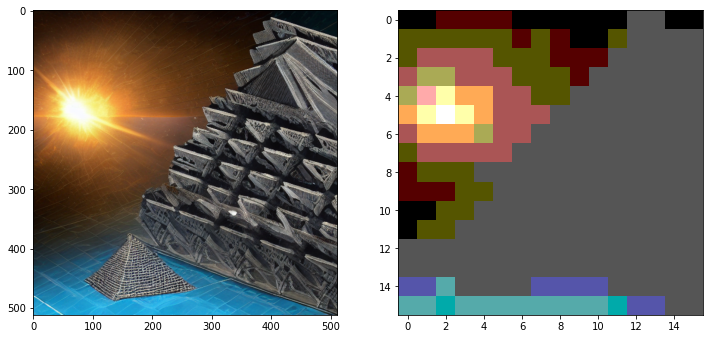

In [1865]:
timg = Image.open('../raw_data/sac-000000/11175_3.png')

plot_quantrgb(timg)

plt.savefig('../results/quan_rbg.png', facecolor = 'white')

In [1859]:
qcolour_encode_image(timg)

array([ 15,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   0,   0,
         0,   0,   0,  14,   0,   0,   0,  27, 142,   8,   0,   0,   0,
        11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  21,   0,
         0,   0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   7,   1,   0,   0,   0,   3,   1])

In [226]:
import os
all_imgs = os.listdir('../raw_data/sac-000000/')

exist_df = pd.DataFrame({'short_img_path': pd.Series(all_imgs)})

df = exist_df.merge(img_df, how = 'inner').drop_duplicates()

df = df[df['clean_prompt'] != '']

df_loop = df.sort_values('img_rating', ascending = False)[:1000]

In [217]:
# !mkdir ../raw_data/sac_images2

In [230]:
# clip_features_list = []
colour_features_list = []
image_path_list = []

for i, row in tqdm(df_loop.iterrows()):
    
    img_path, caption = row['short_img_path'], row['clean_prompt']
    
    if img_path.endswith('png'):

        img = Image.open(f'../raw_data/sac-000000/{img_path}')

        if img:
            
            # calculate aesthetics here too
            # https://github.com/christophschuhmann/improved-aesthetic-predictor
            
            
#             clip_features_list.append(clip_encode_image(img)[0])

            #img = colours_as_pct(img)
            #colour_features_list.append(colour_encode_image(img)[0])
        
            colour_features_list.append(qcolour_encode_image(img))
            
            
            simple_img = simplify_image(img, num_colors = 256, size = (128, 128))
            
            simple_img = add_border(simple_img, width = 8, caption = caption.replace('_', ' ').replace('.png', ''))

            save_img(simple_img, caption, destination_folder = '../raw_data/sac_images4')

            image_path_list.append(f"{caption}.png")
#     if len(features_list) % 10 == 0:
#         print(len(features_list))
        
        

#image = get_simplified_image(url, caption, destination_folder = '../raw_data/images', num_colors = 256)

1000it [00:54, 18.37it/s]


In [231]:
# image_embeddings = np.stack(clip_features_list)
colour_embeddings = np.stack(colour_features_list)


In [232]:
image_embeddings[:947].shape

NameError: name 'image_embeddings' is not defined

In [ ]:
colour_embeddings[:947].shape

In [233]:
colour_embeddings

array([[14,  0,  0, ...,  0,  0,  0],
       [44,  0,  0, ...,  0,  4,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [14,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0, 11]])

(array([10.,  4.,  1.,  2.,  2.,  3.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.04922694, 0.13698022, 0.22473351, 0.31248679, 0.40024007,
        0.48799335, 0.57574663, 0.66349992, 0.7512532 , 0.83900648,
        0.92675976, 1.01451304, 1.10226633, 1.19001961, 1.27777289,
        1.36552617, 1.45327945, 1.54103274, 1.62878602, 1.7165393 ,
        1.80429258, 1.89204586, 1.97979915, 2.06755243, 2.15530571,
        2.24305899, 2.33081228, 2.41856556, 2.50631884, 2.59407212,
        2.6818254 , 2.76957869, 2.85733197, 2.94508525, 3.03283853,
        3.12059181, 3.2083451 , 3.29609838, 3.38385166, 3.47160494,
        3.55935822, 3.64711151, 3.73486479, 3.82261807, 3.91037135,
        3.99812463, 4.08587792, 4.1736312 , 4.26138448, 4.34913776,
        4.43689105]),
 <BarContainer

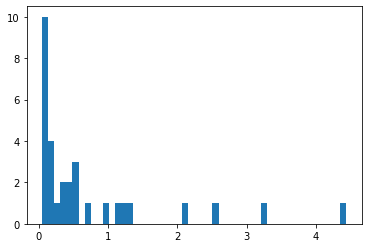

In [234]:
log_col_emb = np.ma.log(colour_embeddings).filled(0)

keep_mask = log_col_emb.mean(axis = 0) > sorted(log_col_emb.mean(axis = 0))[32]

# keep_mask = log_col_emb.sum(axis = 0) > sorted(log_col_emb.sum(axis = 0))[40]

common_colors = log_col_emb[:, keep_mask]

plt.hist(log_col_emb.mean(axis = 0)[keep_mask], bins = 50)

In [235]:
from sklearn.preprocessing import StandardScaler

# s_image_embeddings = StandardScaler().fit_transform(image_embeddings[:947])

s_colour_embeddings = StandardScaler().fit_transform(common_colors)

In [1816]:
len(image_path_list)

947

In [1758]:
both_embeddings = np.hstack([s_image_embeddings, s_colour_embeddings])

In [236]:
img_array_list = [np.array(Image.open(f'../raw_data/sac_images4/{image_path}'))/255 for image_path in image_path_list]

In [237]:
import pymde

# image_mde = pymde.preserve_neighbors(s_image_embeddings, embedding_dim=2)
# mde_image_2d = image_mde.embed()

# image_mde = pymde.preserve_neighbors(both_embeddings, embedding_dim=2)
# mde_both_2d = image_mde.embed()

colour_mde = pymde.preserve_neighbors(s_colour_embeddings, embedding_dim=2)
mde_colour_2d = colour_mde.embed()

Aug 24 04:04:53 AM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 24 04:04:53 AM: The following items have duplicates [ 21  26  29  30  38  44  54  65  70  71  79  82  85  89  90 116 126 130
 140 141 150 151 165 170 174 175 180 185 187 189 198 199 201 209 220 238
 255 258 261 265 270 272 290 293 299 303 329 330 332 339 346 354 361 369
 377 380 394 405 420 431 441 450 462 483 491 501 504 513 516 541 552 556
 561 609 622 625 664 681 716 740 774 777 785 790 807 848 850 871 876 900
 901 906 910 930 934 943 944 959 960 970 987]


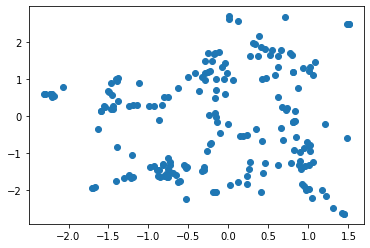

In [1760]:
import matplotlib.pyplot as plt
plt.scatter(mde_both_2d[-200:, 0], mde_both_2d[-200:, 1])

In [1763]:
from umap import UMAP

umap_image_2d = UMAP().fit_transform(s_image_embeddings)
umap_colour_2d = UMAP().fit_transform(s_colour_embeddings)

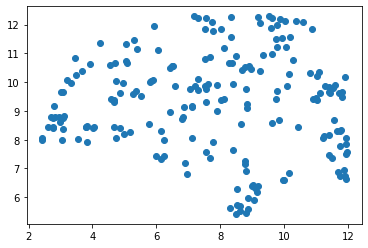

In [468]:
import matplotlib.pyplot as plt
plt.scatter(umap_colour_2d[-200:, 0], umap_colour_2d[-200:, 1])

In [240]:
from sklearn.decomposition import PCA

In [1765]:
# create and fit a 2d PCA


pca = PCA(2)
pca.fit(s_image_embeddings)

pca.explained_variance_

# actually project only PC's
pca_image_2d = pca.transform(s_image_embeddings)

In [241]:
pca = PCA(2)
pca_colour_2d = pca.fit_transform(s_colour_embeddings)
pca.explained_variance_

array([3.51220032, 3.14824482])

In [242]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize
from tqdm import tqdm
import numpy as np
from PIL import Image

def show_xy_images(x_coords, y_coords, img_arr_list, image_zoom=1):
    fig, ax = plt.subplots(1,1, figsize=(25, 25))
    artists = []
    for x_coord, y_coord, img in tqdm(zip(x_coords, y_coords, img_arr_list)):
        c_img = resize(img, [50,50])
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x_coord, y_coord),
                            xycoords='data',
                            frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.stack([x_coords, y_coords], axis=1))
    ax.autoscale()

200it [00:02, 95.84it/s] 


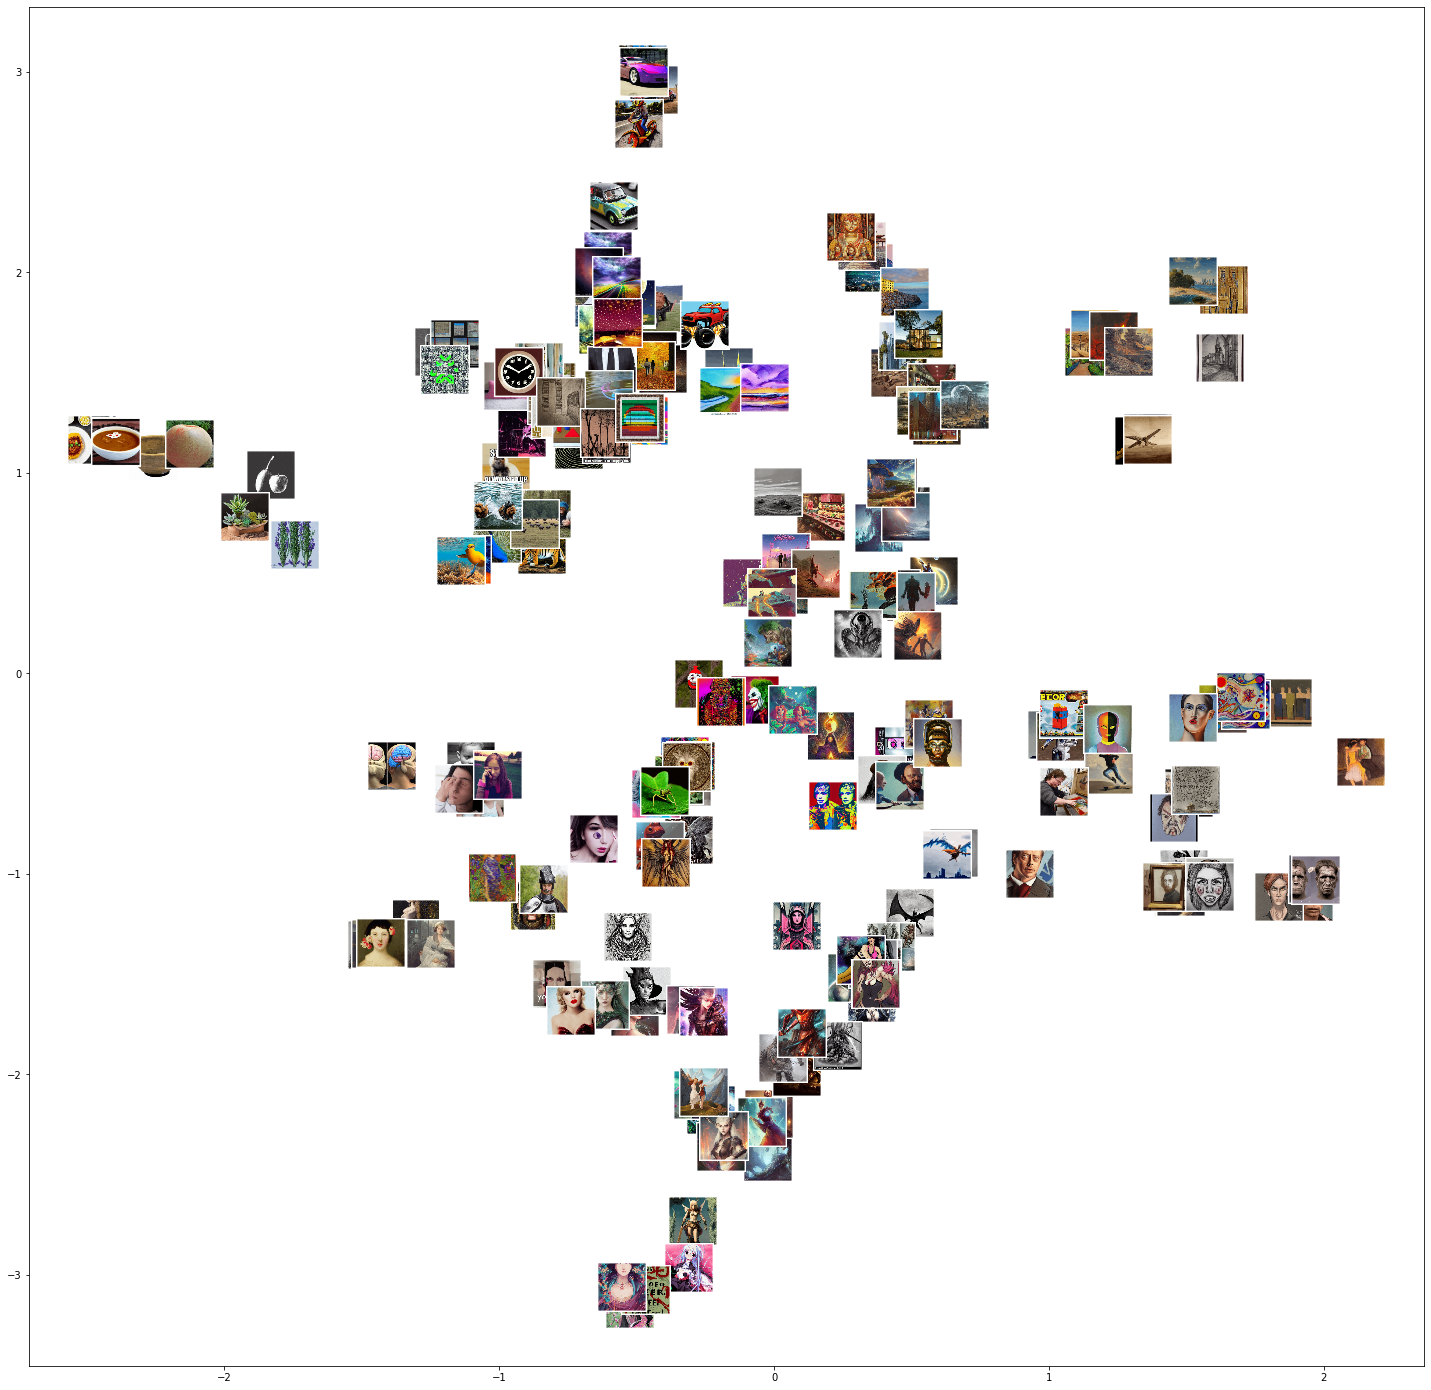

In [1862]:
show_xy_images(x_coords = mde_image_2d[-200:, 0], 
               y_coords = mde_image_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])

# plt.savefig('../results/clip_world.png', facecolor = 'white')


/var/folders/_n/rrz6mzy13l71h2mg878ykrv80000gn/T/ipykernel_88750/1412059648.py:1: RuntimeWarning: divide by zero encountered in log
  show_xy_images(x_coords = np.log(pca_colour_2d[-200:, 0] - min(pca_colour_2d[-200:, 0])),
200it [00:00, 897.44it/s]


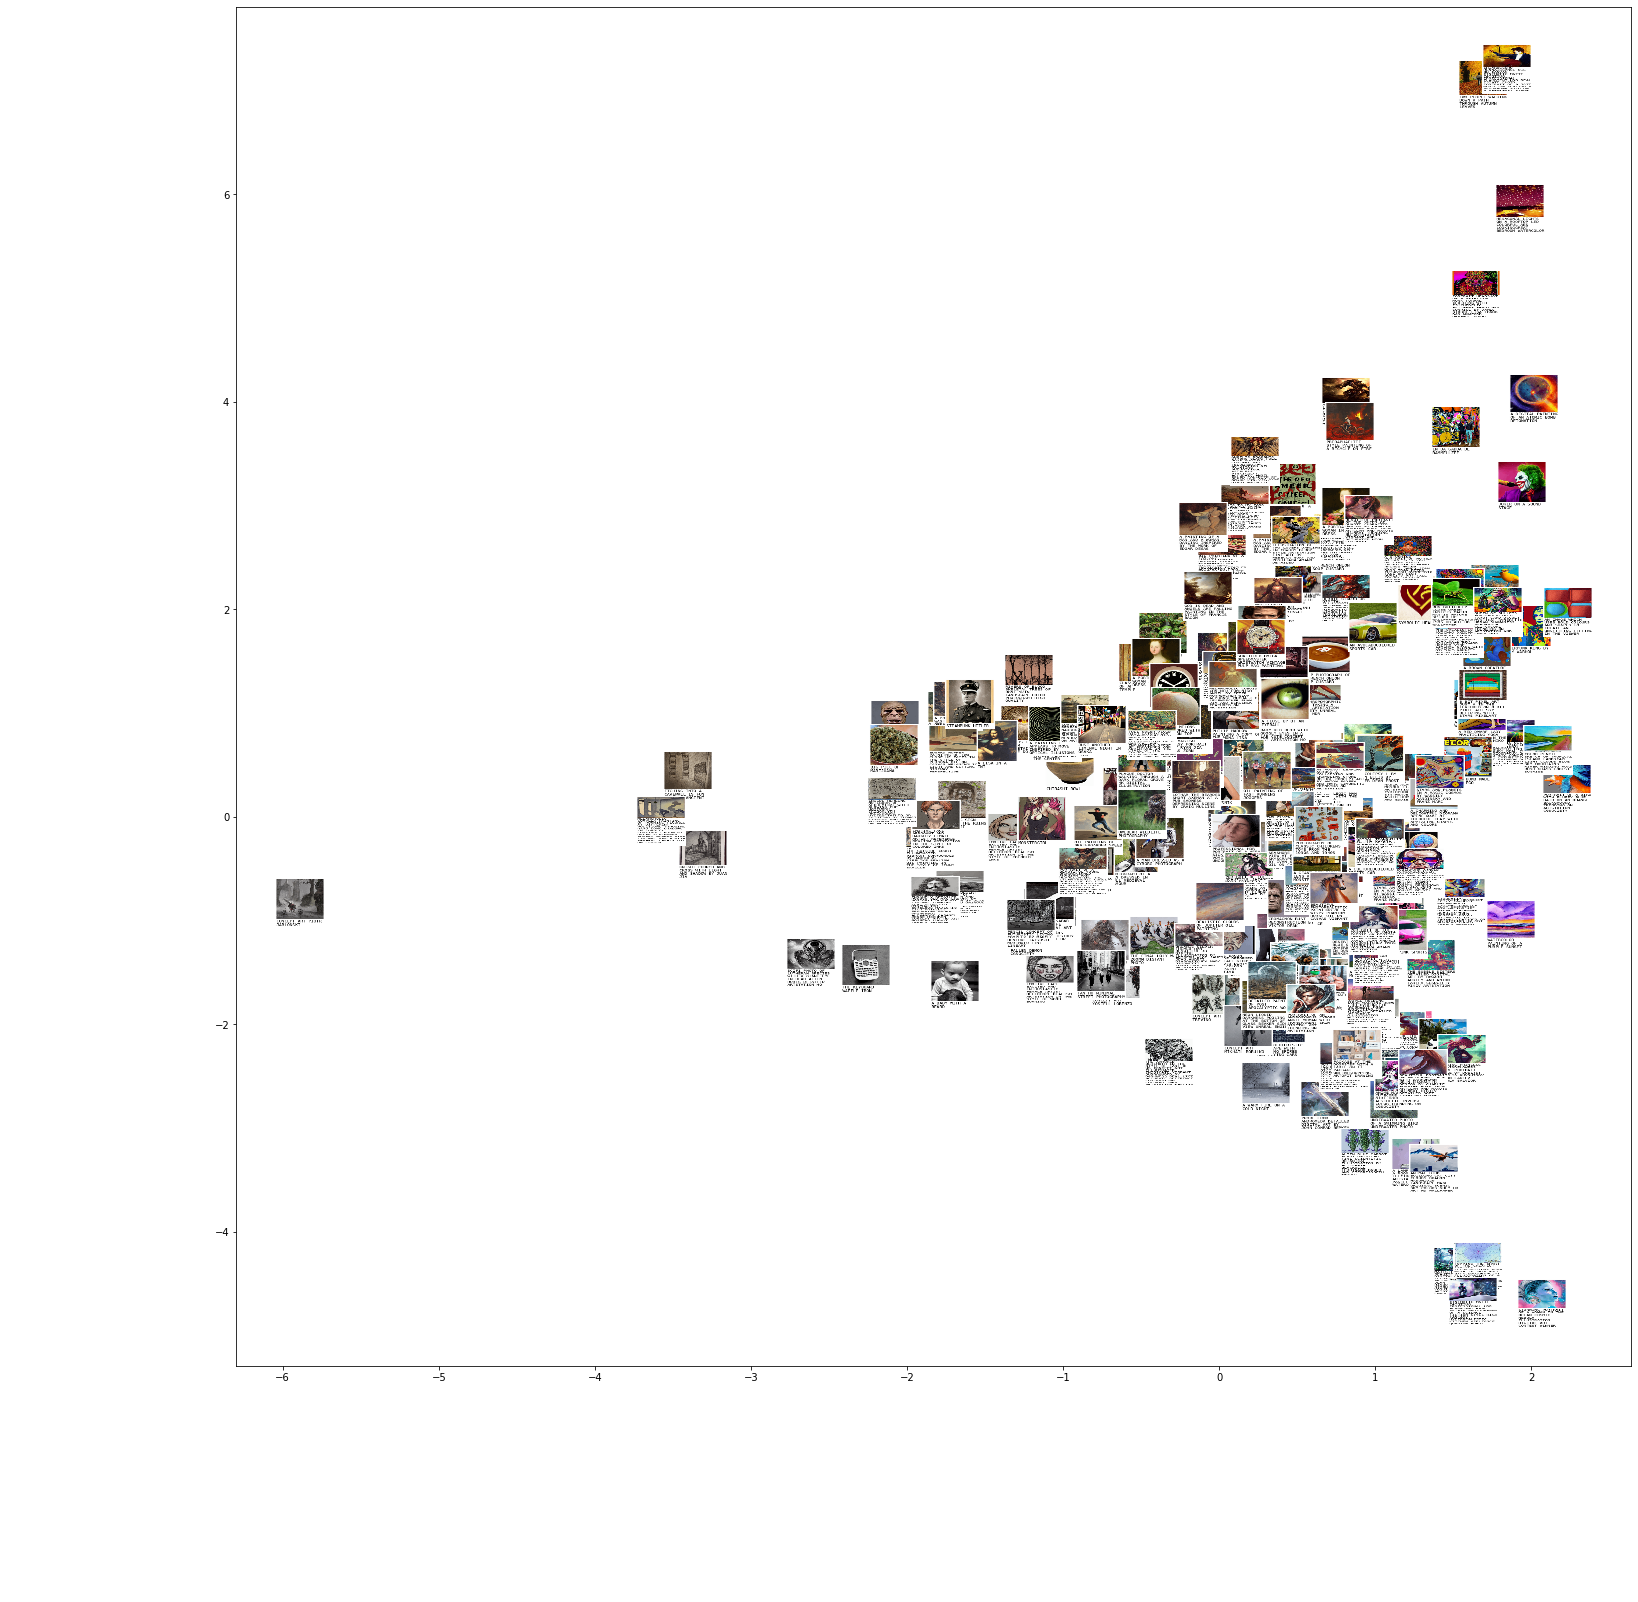

In [243]:
show_xy_images(x_coords = np.log(pca_colour_2d[-200:, 0] - min(pca_colour_2d[-200:, 0])), 
               y_coords = pca_colour_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])

# plt.savefig('../results/colour_world.png', facecolor = 'white')

# show_xy_images(x_coords = pca_colour_2d[-200:, 0], 
#                y_coords = pca_colour_2d[-200:, 1], 
#                img_arr_list = img_array_list[-200:])

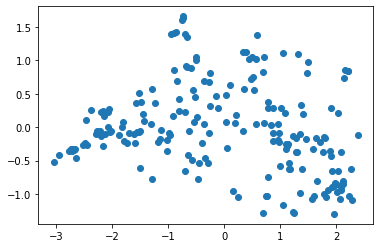

In [194]:
import matplotlib.pyplot as plt
plt.scatter(colour_2d[-200:, 0], colour_2d[-200:, 1])

In [1851]:
!mkdir ../raw_data/sac_images_subset4

In [1854]:
# check images are the correct size
# base_folder = '../raw_data/sac_images_subset/'
# [name for name in os.listdir(base_folder) if Image.open(f'{base_folder}/{name}').size[0] != 136]

[]

In [1852]:
import shutil

for path in image_path_list[-200:]:
    shutil.copy2(f'../raw_data/sac_images4/{path}', f'../raw_data/sac_images_subset4/{path}')

In [1847]:
def embedding_to_coords(embedding, scale = 1000, log = False):
    
    from_one = embedding + abs(embedding.min())
    
    if log:
        from_one = np.ma.log(from_one).filled(0)
        from_one = from_one + abs(from_one.min())
        
    return [int(coord) for coord in (from_one / max(from_one) * scale)]

In [1848]:
# take 200 images with the highest rating
import json

X_image_coords = embedding_to_coords(mde_image_2d[-200:, 0], scale = 1000)
Y_image_coords = embedding_to_coords(mde_image_2d[-200:, 1], scale = 1000)
X_colour_coords = embedding_to_coords(pca_colour_2d[-200:, 0], scale = 1000, log = True)
Y_colour_coords = embedding_to_coords(pca_colour_2d[-200:, 1], scale = 1000)

map_json = {
    "X_image_coords": X_image_coords,
    "Y_image_coords": Y_image_coords,
    "X_colour_coords": X_colour_coords,
    "Y_colour_coords": Y_colour_coords,
    "image_paths": image_path_list[-200:]
}

with open('../raw_data/sac4_latent_space_map.json', 'w') as f:
    json.dump(map_json, f)


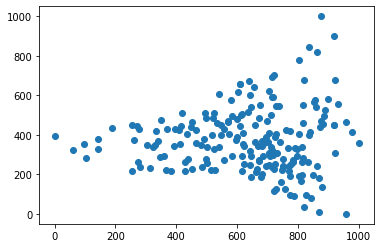

In [1849]:
plt.scatter(map_json['X_colour_coords'], map_json['Y_colour_coords'])

In [ ]:
# copy raw_data/sac_latent_space_map.json into the game assests folder

## Background

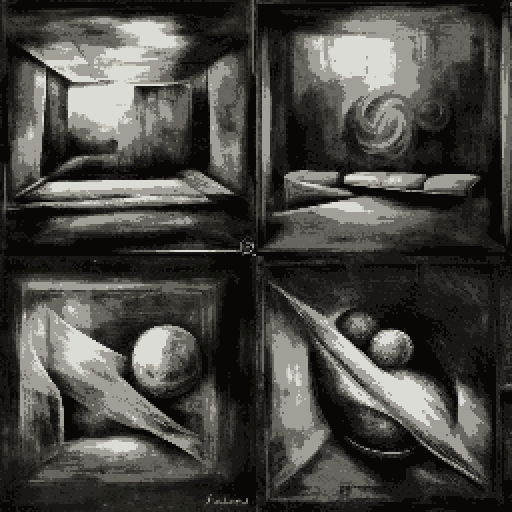

In [281]:
pil_img = Image.open('../raw_data/mj_background.png')
img = pil_img.quantize(colors=32, method=2).resize((256, 256), Image.LANCZOS).resize((512, 512), Image.LANCZOS)
img

In [282]:
img.save('../raw_data/latent_space_background_32bit.png')